In [1]:
import math
import numpy as np
import pandas as pd
from cmath import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Use MRI features to predict Cognitive(CSF) scores 

# read the MRI and CSF data
mri_df = pd.read_excel('MRI-preprocess.xlsx') # Features
csf_df = pd.read_csv('CSF_task_mode.csv') # Tasks 

# Standardize the data
mri_df = (mri_df - mri_df.mean())/mri_df.std() # 2217 rows
csf_df = (csf_df - csf_df.mean())/csf_df.std() # 2217 rows

# Convert df into matrix form
X = np.array(mri_df) #(n_samples, n_features) (2217, 327)
y = np.array(csf_df) #(n_samples, n_tasks) (2217, 7)

# Splitting the dataset 
X_train_pre, X_test, y_train_pre, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_pre, y_train_pre, test_size = 0.2, random_state = 0)

X_training_data = X_train_pre 
y_training_data = y_train_pre 
X_test_data = X_test 
y_test_data = y_test 
X_training_set = X_train 
y_training_set = y_train 
X_validation_set = X_dev 
y_validation_set = y_dev 

In [2]:
# Convert all nan entries in csf (cognitive scores dataset) data to 0
def incomplete_labels_data_one_task(y):
    for i in range(y.shape[0]): 
        for j in range(y.shape[1]):
            if math.isnan(y[i,j]) == True: # if the data doesn't exists
                y[i,j] = 0
    return y

# Dealing the Nan data of output    
y_training_data = incomplete_labels_data_one_task(y_training_data)
y_training_set = incomplete_labels_data_one_task(y_training_set)
y_validation_set = incomplete_labels_data_one_task(y_validation_set)
y_test_data = incomplete_labels_data_one_task(y_test_data)

### Training with gradient descent 

### Ridge regression

In [3]:
# TRAINING with gradient descent and validation # RIDGE REGRESSION
# Compute w using gradient descent

def gradient_descent(learn_rate = 0.1, alpha = 0.01, num_iters = 1000, min_gap = 0.001):
    # initializing weights
    w = np.zeros((X_training_set.shape[1], y_training_set.shape[1])) # (328, 7)
    
    cost_record = list()
    cost_record.append(0)
    
    for i in range(num_iters):           
        # cost = (XW - Y)^(2) + (alpha * W.T * W)
        cost = np.sum((np.dot(X_training_set, w)-y_training_set)**2) + alpha * np.linalg.norm(w)
        cost = cost/X_training_set.shape[0]  # We are averaging the error for numerical stability. Grad is also averaged.
        cost_record.append(cost)

        # grad = (-2 * X.T * Y) + (2 * X.T * X * W) + (2 * alpha * W)
        grad = ((-2*(np.dot(X_training_set.T, y_training_set))) 
                 + (2*np.linalg.multi_dot([X_training_set.T, X_training_set, w]))) + 2*alpha*w
        grad = grad/X_training_set.shape[0]

        w = w - learn_rate * grad

        if i != 0:
            if (abs(cost_record[i-1] - cost_record[i])) < min_gap:
                break
        
    # Calculate prediction f
    f = np.dot(X_validation_set, w)
    # Calculate mse value
    mse_value = mean_squared_error(y_validation_set, f)
    print("MSE value:", mse_value)
    print("Number of iterations:", i)
    return w, cost_record

w, cost = gradient_descent(learn_rate = 0.0001, alpha = 0.001, num_iters = 10000, min_gap = 0.00001)

# There may not be significant changes in result as lr and alpha changes. It depends on the data.

MSE value: 0.13972194024025159
Number of iterations: 3941


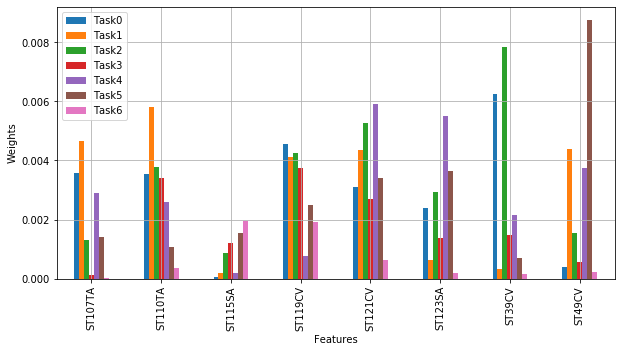

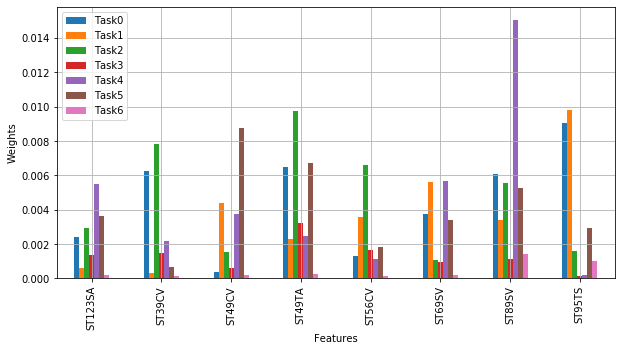

In [4]:
## VISUALIZING THE WEIGHTS OF BIOMARKERS

# Convert weights matrix to pandas dataframe
weights_df = pd.DataFrame(data = w[0:,0:], index = [i for i in range(w.shape[0])], 
                          columns = ['Task' + str(i) for i in range(w.shape[1])]) # (327, 7)

# Convert features to list and add it to weights df
mri_features_list = mri_df.columns.to_list()
weights_df['features'] = mri_features_list

# Get only the features with positive weights
weights_df = weights_df[weights_df.select_dtypes(include=[np.number]).ge(0).all(1)]

weights_df_head = weights_df.head(8)
weights_df_tail = weights_df.tail(8)

weights_df_head.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

weights_df_tail.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

#### It is good to track the cost computed. It helps if optimization go in right way. Ex: Cost starts with 0.96 and ends in  0.85

In [5]:
print(w, cost)

[[ 1.59281298e-03 -1.05779587e-02  9.27238278e-04 ...  4.31093608e-03
  -3.86272317e-03  4.80206811e-04]
 [-9.24367673e-04 -2.23214774e-03  1.25353897e-03 ...  3.05023586e-03
   1.91671535e-03 -5.86528662e-04]
 [-2.75868562e-03 -5.29499986e-03  1.14429003e-03 ...  3.80615518e-04
   5.70600096e-04  1.01234573e-03]
 ...
 [-3.62671241e-05 -1.57185875e-03 -7.78397344e-03 ... -5.84405993e-03
  -8.49754834e-04  4.27764681e-04]
 [ 4.43614738e-04  5.59307486e-03 -4.49308359e-03 ...  5.85233646e-04
   1.35871402e-03 -1.59571218e-03]
 [ 1.48036945e-03 -1.97765661e-04  2.33829316e-03 ...  8.82065753e-04
  -2.95599284e-03 -5.21735841e-04]] [0, 0.9627447703162556, 0.9616949470190217, 0.9606655960192512, 0.9596562580570139, 0.9586664844659546, 0.9576958369258027, 0.9567438872207168, 0.9558102170033266, 0.9548944175643302, 0.953996089607524, 0.9531148430301304, 0.952250296708296, 0.9514020782876471, 0.9505698239787689, 0.9497531783575036, 0.9489517941699475, 0.9481653321420348, 0.9473934607936028, 0.

In [6]:
# PREDICTION AND EVALUATION

f = np.dot(X_test_data, w) # f is the prediction

# mse_value = np.dot(((y_test_data - f).T), (y_test_data - f))/n # This method of calculation of mse value is also accepted
mse_value = mean_squared_error(y_test_data, f)
print("MSE value:", mse_value)

# Report nrmse (Normalized Root Mean Squared Error)
nrmse = math.sqrt(mse_value)/ (y_test_data.max() - y_test_data.min())
print("nrMSE:", nrmse)

# check predictions against the actual values by using the RMSE commonly used to evaluate regression tasks
rmse = (np.sqrt(mean_squared_error(y_test_data, f))) # for rmse, the lower the value is, the better the fit
print("rMSE:", rmse)

# Calculate rmse values for all the seven time periods (tasks)
up = 0
rMSE_ridge_list = list()
for i in range(y_test_data.shape[1]):
    mse1 = mean_squared_error(y_test_data[:,i], f[:,i])
    n_mse = mse1*y_test_data.shape[0]
    up = up + n_mse/np.var(y_test_data[:,i])
    nmse = up/(y_test_data.shape[0]*y_test_data.shape[1])
    rMSE_ridge_list.append(nmse)
    print("rMSE",i+1,":",nmse)

MSE value: 0.15143668416241
nrMSE: 0.06422178193140429
rMSE: 0.3891486658879997
rMSE 1 : 0.138551947804887
rMSE 2 : 0.28282312173650836
rMSE 3 : 0.4115374058218573
rMSE 4 : 0.5647666187939052
rMSE 5 : 0.6921223259720503
rMSE 6 : 0.8315261147261117
rMSE 7 : 0.9748132977786873


### Training with gradient descent 

### Lasso regression

In [7]:
# TRAINING with gradient descent # LASSO 

def soft_threshold(alpha, w):
    if np.sum(w) > alpha:
        return np.abs(w) - alpha
    elif np.sum(w) < -alpha:
        return np.abs(w) + alpha
    else:
        return 0

# Compute w using gradient descent
def gradient_descent(learn_rate = 0.1, alpha = 0.01, num_iters = 1000, min_gap = 0.001):
    # initializing weights
    w = np.zeros((X_training_set.shape[1], y_training_set.shape[1])) # (328, 7)
    
    cost_record = list()
    for i in range(num_iters):
        
        # computing cost
        # cost = (XW - Y)^(2) + (alpha *|W|)
        cost = np.sum((np.dot(X_training_set, w)-y_training_set)**2) + np.sum(alpha * np.abs(w))
        cost = cost / X_training_set.shape[0]
        cost_record.append(cost)
        
        # grad = (-2 * X.T * Y) + (2 * X.T * X * W) + soft_thresh(alpha, w)
        grad = -2*(np.dot(X_training_set.T, y_training_set)) 
        + 2*(np.linalg.multi_dot([X_training_set.T, X_training_set, w])) + soft_threshold(alpha, w)
        grad = grad / X_training_set.shape[0]

        w = w - learn_rate*grad
        
        if i != 0:
            if (cost_record[i-1] - cost_record[i]) < min_gap:
                break
        
    # Calculate prediction f
    f = np.dot(X_validation_set, w)
    # Calculate mse value
    mse_value = mean_squared_error(y_validation_set, f)
    print("MSE value:", mse_value)
    print("Number of iterations:", i)
    
    return w, cost_record

w, cost = gradient_descent(learn_rate = 0.0001, alpha = 0.001, num_iters = 10000, min_gap = 0.0001)

MSE value: 0.13818220435019715
Number of iterations: 93


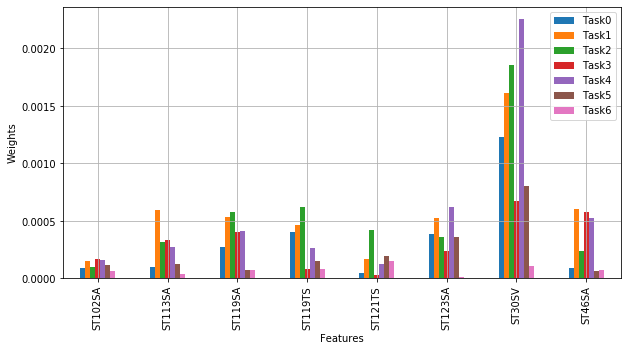

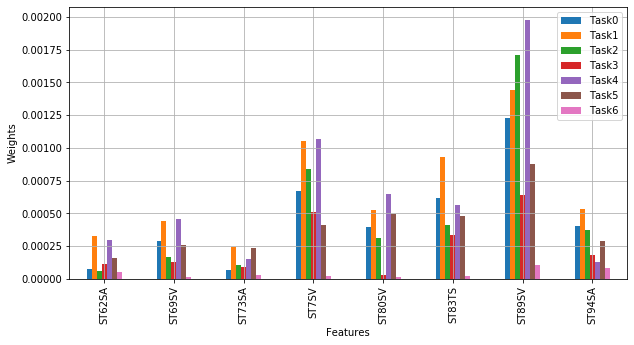

In [8]:
## VISUALIZING THE WEIGHTS OF BIOMARKERS

# Convert weights matrix to pandas dataframe
weights_df = pd.DataFrame(data = w[0:,0:], index = [i for i in range(w.shape[0])], 
                          columns = ['Task' + str(i) for i in range(w.shape[1])]) # (327, 7)

# Convert features to list and add it to weights df
mri_features_list = mri_df.columns.to_list()
weights_df['features'] = mri_features_list

# Get only the features with positive weights
weights_df = weights_df[weights_df.select_dtypes(include=[np.number]).ge(0).all(1)]

weights_df_head = weights_df.head(8)
weights_df_tail = weights_df.tail(8)

weights_df_head.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

weights_df_tail.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

In [9]:
print(w, cost)

[[-2.41302562e-04 -6.56543925e-04 -3.83925436e-04 ... -1.57792797e-04
  -3.25992702e-04 -1.30194927e-05]
 [-2.31449803e-04 -4.21232850e-04 -4.82456897e-04 ... -3.56601719e-04
  -1.10825827e-04 -5.20531631e-05]
 [ 8.85370329e-05  1.48725660e-04  9.90870115e-05 ...  1.58573697e-04
   1.17958034e-04  5.99599178e-05]
 ...
 [-1.11382054e-03 -1.55231108e-03 -2.06575240e-03 ... -1.90449876e-03
  -7.66681820e-04 -1.15650179e-04]
 [-3.76353445e-05  2.36077923e-05 -3.74211182e-04 ... -3.06259394e-04
  -6.14232061e-05 -5.68910478e-05]
 [ 2.21577804e-04  2.12257033e-04  1.77559091e-04 ...  1.95359292e-04
  -3.96369233e-05 -3.25898948e-05]] [0.9627447703162556, 0.9616949545233252, 0.9606554913779674, 0.9596263808801816, 0.9586076230299684, 0.9575992178273274, 0.9566011652722592, 0.9556134653647632, 0.9546361181048396, 0.9536691234924887, 0.9527124815277097, 0.9517661922105036, 0.9508302555408699, 0.9499046715188082, 0.9489894401443193, 0.9480845614174026, 0.9471900353380583, 0.9463058619062866, 0.9

In [10]:
# PREDICTION AND EVALUATION

f = np.dot(X_test_data, w) # f is the prediction

# mse_value = np.dot(((y_test_data - f).T), (y_test_data - f))/n # This method of calculation of mse value is also accepted
mse_value = mean_squared_error(y_test_data, f)
print("MSE value:", mse_value)

# Report nrmse (Normalized Root Mean Squared Error)
nrmse = math.sqrt(mse_value)/ (y_test_data.max() - y_test_data.min())
print("nrMSE:", nrmse)

# check predictions against the actual values by using the RMSE commonly used to evaluate regression tasks
rmse = (np.sqrt(mean_squared_error(y_test_data, f))) # for rmse, the lower the value is, the better the fit
print("rMSE:", rmse)

# Calculate rmse values for all the seven time periods (tasks)
up = 0
rMSE_lasso_list = list()
for i in range(y_test_data.shape[1]):
    mse1 = mean_squared_error(y_test_data[:,i], f[:,i])
    n_mse = mse1*y_test_data.shape[0]
    up = up + n_mse/np.var(y_test_data[:,i])
    nmse = up/(y_test_data.shape[0]*y_test_data.shape[1])
    rMSE_lasso_list.append(nmse)
    print("rMSE",i+1,":",nmse)

MSE value: 0.1500731867295811
nrMSE: 0.06393200989339008
rMSE: 0.38739280676024573
rMSE 1 : 0.13797648039584923
rMSE 2 : 0.27473784605158474
rMSE 3 : 0.40276589779823224
rMSE 4 : 0.5466769345519524
rMSE 5 : 0.6807789897385652
rMSE 6 : 0.8193873972247679
rMSE 7 : 0.9615220666513081


### Training with gradient descent 

### Multi Task Lasso regression - L21 norm

In [11]:
# TRAINING with gradient descent # MULTI TASK LASSO REGRESSION

def l21_norm(W):
    l21 = 0
    for i in range(W.shape[0]):
        l21_j = 0
        for j in range(W.shape[1]):
            l21_j += W[i][j]**2
        l21 += math.sqrt(l21_j)
    return l21

# Compute w using gradient descent
def gradient_descent(learn_rate = 0.1, alpha = 0.01, num_iters = 1000, min_gap = 0.001):
    # initializing weights
    w = np.zeros((X_training_set.shape[1], y_training_set.shape[1])) # (328, 7)

    cost_record = list()
    for i in range(num_iters):
        n = X_training_set.shape[0]
        
        # cost = |XW − Y|F^2 + θ|W|2,1
        cost = np.sum((np.dot(X_training_set, w)-y_training_set)**2) + np.sum(alpha * np.sum(np.sqrt(np.sum(w**2,1))))
        cost = cost / X_training_set.shape[0]
        cost_record.append(cost)

        # D = diag(1/np.sum((W.T * W)^(1/2)))
        D = np.diag(np.full(X_training_set.shape[1], np.sqrt(np.sum(w**2,1))))
        
        # grad = (-(X.T * X) + (X.T * X * W))/n + alpha * (diag(W.T * W)^(-1/2)) * W
        grad = -2*(np.dot(X_training_set.T, y_training_set)) + 2*(np.dot(np.dot(X_training_set.T, X_training_set), w)) 
        + alpha*l21_norm(w)
        grad = grad / X_training_set.shape[0]

        w = w - learn_rate * grad # (328, 7)

        if i != 0:
            if (cost_record[i-1] - cost_record[i]) < min_gap:
                break
        
    # Calculate prediction f
    f = np.dot(X_validation_set, w)
    # Calculate mse value
    mse_value = mean_squared_error(y_validation_set, f)
    print("MSE value:", mse_value)
    print(i)
    
    return w, cost_record

w, cost = gradient_descent(learn_rate = 0.0001, alpha = 0.001, num_iters = 10000, min_gap = 0.0001)

MSE value: 0.13675562679146555
222


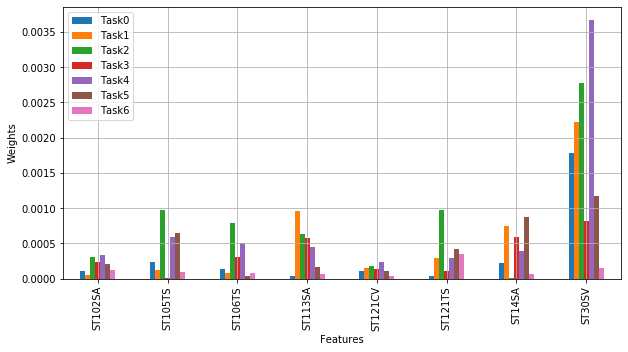

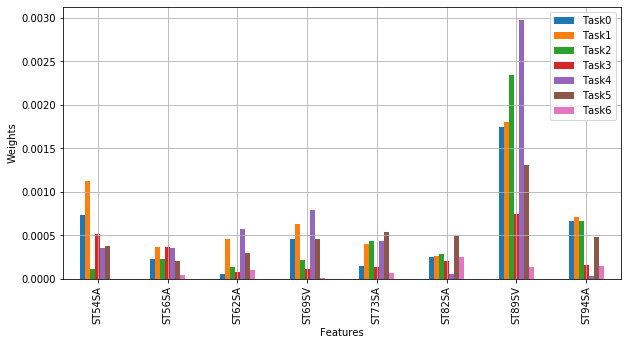

In [12]:
## VISUALIZING THE WEIGHTS OF BIOMARKERS

# Convert weights matrix to pandas dataframe
weights_df = pd.DataFrame(data = w[0:,0:], index = [i for i in range(w.shape[0])], 
                          columns = ['Task' + str(i) for i in range(w.shape[1])]) # (327, 7)

# Convert features to list and add it to weights df
mri_features_list = mri_df.columns.to_list()
weights_df['features'] = mri_features_list

# Get only the features with positive weights
weights_df = weights_df[weights_df.select_dtypes(include=[np.number]).ge(0).all(1)]

weights_df_head = weights_df.head(8)
weights_df_tail = weights_df.tail(8)

weights_df_head.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

weights_df_tail.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

In [13]:
print(w, cost)

[[-1.39641292e-04 -1.02210770e-03 -1.16675234e-04 ...  3.07725967e-04
  -4.80988808e-04  1.60359111e-05]
 [ 4.62884647e-05 -1.73264500e-04  3.18791770e-05 ...  2.40371516e-04
   1.47948015e-04 -5.08393686e-05]
 [ 1.04779058e-04  5.40823308e-05  3.10460604e-04 ...  3.31397922e-04
   2.08942936e-04  1.26157898e-04]
 ...
 [-1.08955560e-03 -1.41856984e-03 -2.35386961e-03 ... -2.00951206e-03
  -7.68758142e-04 -1.00292122e-04]
 [ 1.52321818e-04  4.84056249e-04 -3.84301262e-04 ... -1.65698494e-04
   5.53475049e-05 -1.04177779e-04]
 [ 3.57000950e-04  2.39998814e-04  2.78976244e-04 ...  2.71920763e-04
  -1.79391411e-04 -8.06192836e-05]] [0.9627447703162556, 0.961694950178078, 0.9606656023059078, 0.9596562674402161, 0.958666496915043, 0.9576958524105081, 0.9567439057111569, 0.955810238469999, 0.9548944419781092, 0.953996116939656, 0.9531148732522277, 0.952250329792335, 0.9514021142059604, 0.9505698627040435, 0.9497532198627755, 0.9489518384285973, 0.9481653791277836, 0.9473935104805082, 0.946635

In [14]:
# PREDICTION AND EVALUATION

f = np.dot(X_test_data, w) # f is the prediction

# mse_value = np.dot(((y_test_data - f).T), (y_test_data - f))/n # This method of calculation of mse value is also accepted
mse_value = mean_squared_error(y_test_data, f)
print("MSE value:", mse_value)

# Report nrmse (Normalized Root Mean Squared Error)
nrmse = math.sqrt(mse_value)/ (y_test_data.max() - y_test_data.min())
print("nrMSE:", nrmse)

# check predictions against the actual values by using the RMSE commonly used to evaluate regression tasks
rmse = (np.sqrt(mean_squared_error(y_test_data, f))) # for rmse, the lower the value is, the better the fit
print("rMSE:", rmse)

# Calculate rmse values for all the seven time periods (tasks)
up = 0
rMSE_mtl_list = list()
for i in range(y_test_data.shape[1]):
    mse1 = mean_squared_error(y_test_data[:,i], f[:,i])
    n_mse = mse1*y_test_data.shape[0]
    up = up + n_mse/np.var(y_test_data[:,i])
    nmse = up/(y_test_data.shape[0]*y_test_data.shape[1])
    rMSE_mtl_list.append(nmse)
    print("rMSE",i+1,":",nmse)

MSE value: 0.14940264752699012
nrMSE: 0.0637890232859856
rMSE: 0.3865263865856898
rMSE 1 : 0.13787780284378376
rMSE 2 : 0.2745936861691151
rMSE 3 : 0.40177338620687625
rMSE 4 : 0.545050660301292
rMSE 5 : 0.677364717830183
rMSE 6 : 0.8153113912742262
rMSE 7 : 0.9574416441767206


### Training with gradient descent 

### Temporal Group Lasso 

In [15]:
# TRAINING with coordinate descent # TEMPORAL GROUP LASSO 

def l21_norm(W):
    l21 = 0
    for i in range(W.shape[0]):
        l21_j = 0
        for j in range(W.shape[1]):
            l21_j += W[i][j]**2
        l21 += math.sqrt(l21_j)
    return l21

# Compute w using gradient descent
def gradient_descent(learn_rate = 0.01, alpha = 5.6, num_iters = 1000, min_gap = 0.001):
    # weights 
    w = np.zeros((X_training_set.shape[1], y_training_set.shape[1])) # (328, 7)
    
    cost_record = list()
    
    # Set H matrix for Temporal Smoothness prior
    H = np.zeros((y_training_set.shape[1], y_training_set.shape[1]-1))
    for i in range(y_training_set.shape[1]):
        for j in range(y_training_set.shape[1]-1):
            if i == j:
                H[i,j] = 1
            elif i == j + 1:
                H[i,j] = -1
                
    m1 = np.dot(X_training_set.T, X_training_set) + alpha * np.identity(X_training_set.shape[1])
    m2 = alpha * np.dot(H, H.T)
    derta1, Q1 = np.linalg.eig(m1)
    derta2, Q2 = np.linalg.eig(m2)
    D = np.dot(np.dot(np.dot(Q1.T, X_training_set.T), y_training_set), Q2)
    W = np.zeros((derta1.shape[0], derta2.shape[0]))
    for i in range(derta1.shape[0]):
        for j in range(derta2.shape[0]):
            W[i][j] = D[i][j]/(derta1[i]+derta2[j])
    w = np.dot(np.dot(Q1, W), Q2.T)
        
    for iter in range(num_iters):
        n = X_training_set.shape[0]
         
        # cost = |XW − Y|F^2 + θ1|W|F^2 + θ2|WH|F^2 + θ3|W|2,1
        cost = np.sum((np.dot(X_training_set, w)-y_training_set)**2) + (alpha * np.linalg.norm(w)) 
        + (alpha * np.linalg.norm(np.dot(w,H)**2)) + alpha * np.sum(np.sqrt(np.sum(w**2,1))) 
        cost = cost / X_training_set.shape[0]
        cost_record.append(cost)

        # grad = -(X.T * y) + (X.T * X * W) + (alpha * W) + (alpha * W * H * H.T) + (alpha * D * W)
        grad = -2*(np.dot(X_training_set.T, y_training_set)) + 2*(np.dot(np.dot(X_training_set.T, X_training_set), w)) 
        + 2*alpha*w + 2*alpha*np.dot(w, np.dot(H, H.T)) + alpha*l21_norm(w)
        
        w = w - learn_rate * grad/X_training_set.shape[0] # (328, 7)
                
    # Calculate prediction f
    f = np.dot(X_validation_set, w)
    # Calculate mse value
    mse_value = mean_squared_error(y_validation_set, f)
    print("MSE value:", mse_value)
    print(iter)
    return w, cost_record
    
w, cost = gradient_descent(learn_rate = 0.0001, alpha = 0.001, num_iters = 1000, min_gap = 0.0001)

MSE value: 0.1359570631505658
999


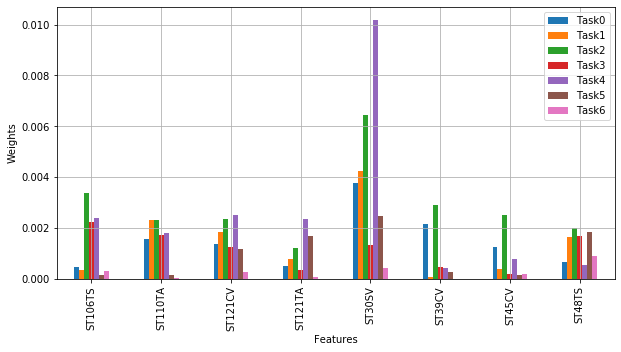

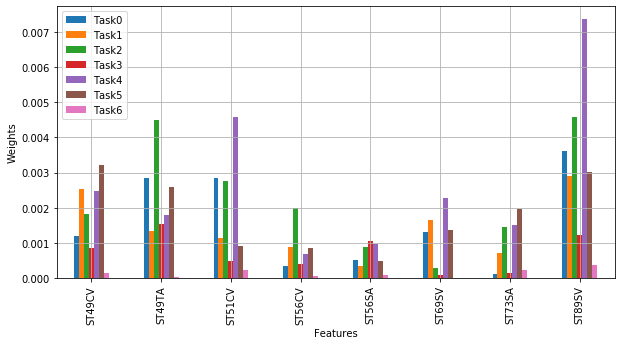

In [16]:
## VISUALIZING THE WEIGHTS OF BIOMARKERS

# Convert weights matrix to pandas dataframe
weights_df = pd.DataFrame(data = w[0:,0:], index = [i for i in range(w.shape[0])], 
                          columns = ['Task' + str(i) for i in range(w.shape[1])]) # (327, 7)

# Convert features to list and add it to weights df
mri_features_list = mri_df.columns.to_list()
weights_df['features'] = mri_features_list

# Get only the features with positive weights
weights_df = weights_df[weights_df.select_dtypes(include=[np.number]).ge(0).all(1)]

weights_df_head = weights_df.head(8)
weights_df_tail = weights_df.tail(8)

# weights_df.plot(x = 'features', y = ['Task0', 'Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6'], kind = 'line')
weights_df_head.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
#plt.xticks(size=8, rotation=25)
plt.show()

weights_df_tail.set_index('features').plot(figsize=(10,5), grid=True, kind = 'bar')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.show()

In [17]:
print(w, cost)

[[ 2.05141510e-04 -3.46710062e-03  5.38953539e-04 ...  1.95997907e-03
  -1.50558080e-03  1.54895880e-04]
 [ 3.24340328e-04 -2.78113200e-04  9.49520446e-04 ...  1.65725007e-03
   8.20818860e-04 -1.46749945e-04]
 [-3.80145677e-04 -1.10866676e-03  6.54885758e-04 ...  5.28751246e-04
   3.94684169e-04  4.23853221e-04]
 ...
 [-1.28983035e-03 -1.50092807e-03 -4.57585934e-03 ... -3.43960409e-03
  -1.03877266e-03 -3.28939450e-05]
 [ 4.68140045e-04  2.12732574e-03 -1.20117191e-03 ...  8.47806225e-05
   3.70163601e-04 -4.59305078e-04]
 [ 8.11732109e-04  1.42698860e-04  6.50464088e-04 ...  3.98960396e-04
  -1.01777157e-03 -2.84918461e-04]] [0.9627447703162556, 0.9616949470190217, 0.9606655960191052, 0.9596562580565833, 0.9586664844651075, 0.9576958369244133, 0.9567438872186664, 0.9558102170005022, 0.9548944175606244, 0.9539960896028356, 0.9531148430243627, 0.9522502967013589, 0.9514020782794537, 0.9505698239692381, 0.9497531783465589, 0.9489517941575164, 0.9481653321280495, 0.9473934607779994, 0.9

In [18]:
# PREDICTION AND EVALUATION
# no need to use the temporal smoothness term here

f = np.dot(X_test_data, w) # f is the prediction

# mse_value = np.dot(((y_test_data - f).T), (y_test_data - f))/n # This method of calculation of mse value is also accepted
mse_value = mean_squared_error(y_test_data, f)
print("MSE value:", mse_value)

# Report nrmse (Normalized Root Mean Squared Error)
nrmse = math.sqrt(mse_value)/ (y_test_data.max() - y_test_data.min())
print("nrMSE:", nrmse)

# check predictions against the actual values by using the RMSE commonly used to evaluate regression tasks
rmse = (np.sqrt(mean_squared_error(y_test_data, f))) # for rmse, the lower the value is, the better the fit
print("rMSE:", rmse)

# Calculate rmse values for all the seven time periods (tasks)
up = 0
rMSE_tgl_list = list()
for i in range(y_test_data.shape[1]):
    mse1 = mean_squared_error(y_test_data[:,i], f[:,i])
    n_mse = mse1*y_test_data.shape[0]
    up = up + n_mse/np.var(y_test_data[:,i])
    nmse = up/(y_test_data.shape[0]*y_test_data.shape[1])
    rMSE_tgl_list.append(nmse)
    print("rMSE",i+1,":",nmse)

MSE value: 0.14841380264887802
nrMSE: 0.06357757399496455
rMSE: 0.38524512021423196
rMSE 1 : 0.1369289567556573
rMSE 2 : 0.27483902210913724
rMSE 3 : 0.40068959302269813
rMSE 4 : 0.546340751078208
rMSE 5 : 0.6749886316067913
rMSE 6 : 0.8114345952560599
rMSE 7 : 0.9532501289171412


Text(0, 0.5, 'Root Mean Squared Error')

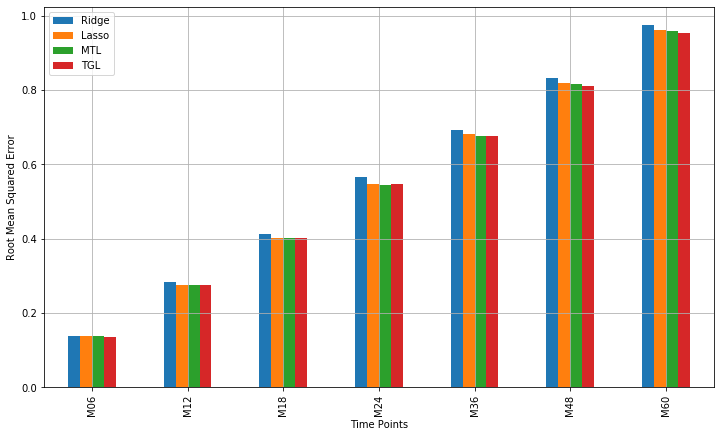

In [19]:
## VISUALIZE THE MSE SCORES FOR ALL THE ALGORITHMS AGAINST THE TASKS

rMSE_df = pd.DataFrame()
rMSE_df['Ridge'] = rMSE_ridge_list
rMSE_df['Lasso'] = rMSE_lasso_list
rMSE_df['MTL'] = rMSE_mtl_list
rMSE_df['TGL'] = rMSE_tgl_list
rMSE_df.index = ['M06', 'M12', 'M18', 'M24', 'M36', 'M48', 'M60']
rMSE_df.plot(figsize=(12,7), grid=True, kind = 'bar')
plt.xlabel('Time Points')
plt.ylabel('Root Mean Squared Error')